In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


Importing libraries

In [ ]:
# ! pip install -q kaggle
# !pip install pandas --upgrade
# !pip3 install pandas_profiling --upgrade
# !pip install pycaret

In [ ]:
import pandas as pd
from pandas_profiling import ProfileReport
import numpy as np

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.impute import KNNImputer
import pycaret.regression as pycr
import lightgbm
from lightgbm import LGBMRegressor
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn import ensemble
from sklearn.ensemble import RandomForestRegressor

Importing Dataset from Kaggle

In [ ]:
!mkdir ~/.kaggle/
!cp /content/gdrive/MyDrive/MABA-6490/Assignment1/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

mkdir: cannot create directory ‘/root/.kaggle/’: File exists


In [ ]:
!kaggle datasets list

ref                                                             title                                       size  lastUpdated          downloadCount  voteCount  usabilityRating  
--------------------------------------------------------------  -----------------------------------------  -----  -------------------  -------------  ---------  ---------------  
akshaydattatraykhare/diabetes-dataset                           Diabetes Dataset                             9KB  2022-10-06 08:55:25          12435        395  1.0              
whenamancodes/covid-19-coronavirus-pandemic-dataset             COVID -19 Coronavirus Pandemic Dataset      11KB  2022-09-30 04:05:11           9903        306  1.0              
thedevastator/240000-household-electricity-consumption-records  Household Electricity Consumption            3MB  2022-10-24 01:22:40            782         21  1.0              
akshaydattatraykhare/data-for-admission-in-the-university       Data for Admission in the University     

In [ ]:
!kaggle datasets download -d ramprasad273/predicting-food-delivery-time

predicting-food-delivery-time.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
!ls

 gdrive    'Participants Data'		        sample_data
 logs.log   predicting-food-delivery-time.zip


In [ ]:
# !cp predicting-food-delivery-time.zip /content/gdrive/MyDrive/MABA-6490/Assignment1/predicting-food-delivery-time.zip
# !unzip /content/gdrive/MyDrive/MABA-6490/Assignment1/predicting-food-delivery-time.zip -d /content/gdrive/MyDrive/MABA-6490/Assignment1/

In [ ]:
! unzip predicting-food-delivery-time.zip

Archive:  predicting-food-delivery-time.zip
replace Participants Data/Data_Test.xlsx? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: Participants Data/Data_Test.xlsx  
replace Participants Data/Data_Train.xlsx? [y]es, [n]o, [A]ll, [N]one, [r]ename: 
error:  invalid response [{ENTER}]
replace Participants Data/Data_Train.xlsx? [y]es, [n]o, [A]ll, [N]one, [r]ename: 
error:  invalid response [{ENTER}]
replace Participants Data/Data_Train.xlsx? [y]es, [n]o, [A]ll, [N]one, [r]ename: 
error:  invalid response [{ENTER}]
replace Participants Data/Data_Train.xlsx? [y]es, [n]o, [A]ll, [N]one, [r]ename: 
error:  invalid response [{ENTER}]
replace Participants Data/Data_Train.xlsx? [y]es, [n]o, [A]ll, [N]one, [r]ename: 
error:  invalid response [{ENTER}]
replace Participants Data/Data_Train.xlsx? [y]es, [n]o, [A]ll, [N]one, [r]ename: 
error:  invalid response [{ENTER}]
replace Participants Data/Data_Train.xlsx? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: Participants Data/Data_Train

In [ ]:
%cd 'Participants Data'
!ls

/content/Participants Data
Data_Test.xlsx	 lgbm_importances-01.png  predicted_data_final.csv
Data_Train.xlsx  lgbm_importances-02.png  Sample_Submission.xlsx


EDA

In [ ]:
test_data = pd.read_excel("/content/Participants Data/Data_Test.xlsx")
train_data = pd.read_excel("/content/Participants Data/Data_Train.xlsx")
output_data = pd.read_excel("/content/Participants Data/Sample_Submission.xlsx")

In [ ]:
test_data = test_data.join(output_data)
test_data

Restaurant                                    Location  \
0       ID_2842  Mico Layout, Stage 2, BTM Layout,Bangalore   
1        ID_730  Mico Layout, Stage 2, BTM Layout,Bangalore   
2       ID_4620                             Sector 1, Noida   
3       ID_5470                  Babarpur, New Delhi, Delhi   
4       ID_3249                             Sector 1, Noida   
...         ...                                         ...   
2769    ID_6342                  Delhi University-GTB Nagar   
2770    ID_8495  Mico Layout, Stage 2, BTM Layout,Bangalore   
2771    ID_7122        Noorkhan Bazaar, Malakpet, Hyderabad   
2772    ID_2475                   D-Block, Sector 63, Noida   
2773    ID_1595              Dockyard Road, Mumbai CST Area   

                                               Cuisines Average_Cost  \
0                       North Indian, Chinese, Assamese         ₹350   
1                                        Biryani, Kebab         ₹100   
2                                             Fast Food         ₹100   
3     Mithai, North Indian, Chinese, Fast Food, Sout...         ₹200   
4                                    Chinese, Fast Food         ₹150   
...                                                 ...          ...   
2769                                 Fast Food, Chinese         ₹100   
2770     Continental, North Indian, Desserts, Beverages         ₹250   
2771                               Andhra, South Indian         ₹150   
2772                                             Bakery         ₹100   
2773                    Italian, Street Food, Fast Food         ₹150   

     Minimum_Order Rating Votes Reviews Delivery_Time  
0              ₹50    4.2   361     225   120 minutes  
1              ₹50    NEW     -       -    20 minutes  
2              ₹50    3.6    36      16    20 minutes  
3              ₹50    3.6    66      33    65 minutes  
4              ₹50    2.9    38      14    45 minutes  
...            ...    ...   ...     ...           ...  
2769           ₹50    NEW     -       -    80 minutes  
2770           ₹50    3.1     5       1    65 minutes  
2771           ₹50    3.0    16       1   120 minutes  
2772           ₹99    3.0     7       2   120 minutes  
2773           ₹50    3.6    99      30    20 minutes  

[2774 rows x 9 columns]

In [ ]:
print(train_data.shape)
print(train_data.columns)
print(train_data.dtypes)

(11094, 9)
Index(['Restaurant', 'Location', 'Cuisines', 'Average_Cost', 'Minimum_Order',
       'Rating', 'Votes', 'Reviews', 'Delivery_Time'],
      dtype='object')
Restaurant       object
Location         object
Cuisines         object
Average_Cost     object
Minimum_Order    object
Rating           object
Votes            object
Reviews          object
Delivery_Time    object
dtype: object


Converting the data type of columns 'Average_Cost', 'Minimum_Order',
       'Rating', 'Votes', 'Reviews', 'Delivery_Time'

In [ ]:
train_data['Average_Cost'] = pd.to_numeric(train_data['Average_Cost'].str.replace('[^0-9]',''))
train_data['Minimum_Order'] = pd.to_numeric(train_data['Minimum_Order'].str.replace('[^0-9]',''))
train_data['Rating'] = pd.to_numeric(train_data['Rating'].str.replace('[^0-9]|[^\w.] ',''))
train_data['Votes'] = pd.to_numeric(train_data['Votes'].str.replace('[^0-9]|[^\w.] ',''))
train_data['Reviews'] = pd.to_numeric(train_data['Reviews'].str.replace('[^0-9]|[^\w.] ',''))
train_data['Delivery_Time'] = pd.to_numeric(train_data['Delivery_Time'].str.replace('[^0-9]|[^\w.] ',''))

In [ ]:
test_data['Average_Cost'] = pd.to_numeric(test_data['Average_Cost'].str.replace('[^0-9]',''))
test_data['Minimum_Order'] = pd.to_numeric(test_data['Minimum_Order'].str.replace('[^0-9]',''))
test_data['Rating'] = pd.to_numeric(test_data['Rating'].str.replace('[^0-9]|[^\w.] ',''))
test_data['Votes'] = pd.to_numeric(test_data['Votes'].str.replace('[^0-9]|[^\w.] ',''))
test_data['Reviews'] = pd.to_numeric(test_data['Reviews'].str.replace('[^0-9]|[^\w.] ',''))
test_data['Delivery_Time'] = pd.to_numeric(test_data['Delivery_Time'].str.replace('[^0-9]|[^\w.] ',''))

In [ ]:
train_profile = ProfileReport(train_data)
train_profile

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
test_profile = ProfileReport(test_data)
test_profile

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Encoding categorical data

In [ ]:
def label_encoder(data, y):
    le = LabelEncoder()
    data[y] = le.fit_transform(data[y])
label_list = ["Restaurant","Location", "Cuisines"]
for l in label_list:
    label_encoder(train_data,l)
    label_encoder(test_data,l)

Handling Missing Values

KNN Imputer

In [ ]:
imputer = KNNImputer(n_neighbors=5, weights="uniform")
knn=imputer.fit_transform(train_data[['Average_Cost', 'Votes', 'Reviews', 'Rating']])
train_data[['Average_Cost', 'Votes', 'Reviews', 'Rating']]=knn

# knn=imputer.fit_transform(test_data[['Average_Cost', 'Votes', 'Reviews', 'Rating']])
# test_data[['Average_Cost', 'Votes', 'Reviews', 'Rating']]=knn
knn=imputer.fit_transform(test_data[['Rating', 'Votes', 'Reviews']])
test_data[['Rating', 'Votes', 'Reviews']]=pd.DataFrame(knn)

In [ ]:
train_data.isna().sum()

Restaurant       0
Location         0
Cuisines         0
Average_Cost     0
Minimum_Order    0
Rating           0
Votes            0
Reviews          0
Delivery_Time    0
dtype: int64

In [ ]:
test_data.isna().sum()

Restaurant       0
Location         0
Cuisines         0
Average_Cost     0
Minimum_Order    0
Rating           0
Votes            0
Reviews          0
Delivery_Time    0
dtype: int64

Reducing Memory usage

Splitting Train dataset

In [ ]:
X_train = train_data.drop(["Delivery_Time"],axis=1)
y_train = train_data['Delivery_Time']

X_test = test_data.drop(["Delivery_Time"],axis=1)
y_test = test_data['Delivery_Time']

<!-- Feature Scaling -->

In [ ]:
# sc = StandardScaler()
# X_train = sc.fit_transform(X_train)
# X_test = sc.fit_transform(X_test)

Baseline Model - Random Forest

In [ ]:
### Plotting helper functions

def plot_residual_distribution(model):
    """
    Density plot of residuals (y_true - y_pred) for testation set for given model
    """
    ax = sns.distplot(y_test - model.predict(X_test), hist = True, kde = True,
                 kde_kws = {'shade': True, 'linewidth': 3}, axlabel="Residual")
    title = ax.set_title('Kernel density of residuals', size=15)

def plot_scatter_pred_actual(model):
    """
    Scatter plot of predictions from given model vs true target variable from testation set
    """
    ax = sns.scatterplot(x=model.predict(X_test), y = y_test)
    ax.set_xlabel('Predictions')
    ax.set_ylabel('Actuals')
    title = ax.set_title('Actual vs Prediction scatter plot', size=15)

In [ ]:
rfc = RandomForestClassifier(random_state = 45)
rfc.fit(X_train,y_train)
y_pred = rfc.predict(X_test)

In [ ]:
print(f"rMSE is {mean_squared_error(y_test, y_pred,squared=False)}")

rMSE is 41.176375164230585


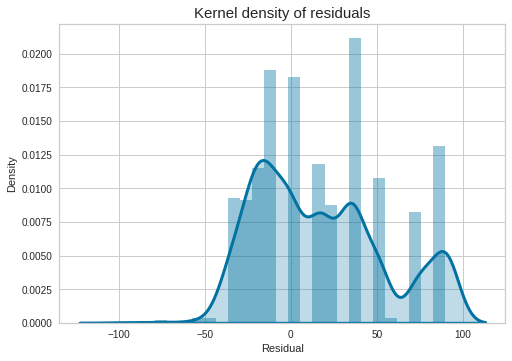

In [ ]:
plot_residual_distribution(rfc)

Improved Model

In [ ]:
gbm = lightgbm.LGBMRegressor(objective='regression',
                              random_state=33,
                              early_stopping_rounds = 250,
                              n_estimators=10000)

gbm.fit(
    X_train,
    y_train,
    eval_set=[(X_test, y_test)],
    eval_metric='l2',  # also the default
    verbose=False,
)

[LightGBM] [Warning] early_stopping_round is set=250, early_stopping_rounds=250 will be ignored. Current value: early_stopping_round=250


LGBMRegressor(early_stopping_rounds=250, n_estimators=10000,
              objective='regression', random_state=33)

In [ ]:
print(f"rMSE is {mean_squared_error(y_test, gbm.predict(X_test),squared=False)}")

rMSE is 39.49732469233309


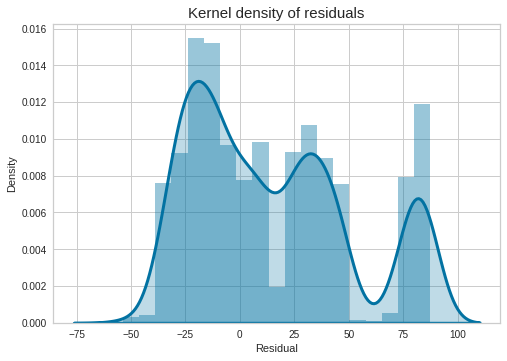

In [ ]:
plot_residual_distribution(gbm)

Hyperparameter Tuning

In [ ]:
gbm2 = lightgbm.LGBMRegressor(objective='regression',
                              random_state=33,
                              early_stopping_rounds = 250,
                              n_estimators=10000,
                              boosting_type='gbdt', num_leaves=151, max_depth=-1, learning_rate=0.001, subsample_for_bin=200000,
                              min_split_gain=0.0, min_child_weight=0.001, min_child_samples=20, subsample=1.0, subsample_freq=0,
                              colsample_bytree=.75, reg_alpha=1.3, reg_lambda=0.1,  n_jobs=- 1,
                              silent=True, importance_type='split'
                             )

gbm2.fit(
    X_train,
    y_train,
    eval_set=[(X_test, y_test)],
    eval_metric='l2',  # also the default
    verbose=False,
)

[LightGBM] [Warning] early_stopping_round is set=250, early_stopping_rounds=250 will be ignored. Current value: early_stopping_round=250


LGBMRegressor(colsample_bytree=0.75, early_stopping_rounds=250,
              learning_rate=0.001, n_estimators=10000, num_leaves=151,
              objective='regression', random_state=33, reg_alpha=1.3,
              reg_lambda=0.1, silent=True)

In [ ]:
print(f"rMSE is {mean_squared_error(y_test, gbm2.predict(X_test),squared=False)}")

rMSE is 39.41730712617706


### Custom Asymmetric Metric

In [ ]:
def custom_asymmetric_rmse(y_true, y_pred):
    residual = (y_true - y_pred).astype("float")
    loss = np.where(residual > 0, (residual**2)*10, residual**2)
    return  np.sqrt((loss).mean())

In [ ]:
print(f"Custom asymmetric rMSE is {custom_asymmetric_rmse(y_test, gbm.predict(X_test))}")

Custom asymmetric rMSE is 117.44344597667296


In [ ]:
print(f"Custom asymmetric rMSE is {custom_asymmetric_rmse(y_test, gbm2.predict(X_test))}")

Custom asymmetric rMSE is 117.46215359379919


Introducing a new custom asymmetric objective

In [ ]:
def custom_asymmetric_objective(y_true, y_pred):
    residual = (y_true - y_pred).astype("float")
    grad = np.where(residual>0, -2*200.0*residual, -2*residual)
    hess = np.where(residual>0, 2*200.0, 2.0)
    return grad, hess

def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

def custom_asymmetric_eval(y_true, y_pred):
    residual = (y_true - y_pred).astype("float")
    loss = np.where(residual > 0, (residual**2)*10.0, residual**2)
    return "custom_asymmetric_eval", np.mean(loss), False

In [ ]:
# make new model on new value

gbm3 = lightgbm.LGBMRegressor(objective='regression',
                              random_state=33,
                              early_stopping_rounds = 250,
                              n_estimators=10000,
                              boosting_type='gbdt', num_leaves=151, max_depth=-1, learning_rate=0.001, subsample_for_bin=200000,
                              min_split_gain=0.0, min_child_weight=0.001, min_child_samples=20, subsample=1.0, subsample_freq=0,
                              colsample_bytree=.75, reg_alpha=1.3, reg_lambda=0.1,  n_jobs=- 1,
                              silent=True, importance_type='split'
                             )
gbm3.set_params(**{'objective': custom_asymmetric_objective}, metrics = ["rmse", 'mae'], )

gbm3.fit(
    X_train,
    y_train,
    eval_set=[(X_test, y_test)],
    verbose=False,
)

[LightGBM] [Warning] early_stopping_round is set=250, early_stopping_rounds=250 will be ignored. Current value: early_stopping_round=250


LGBMRegressor(colsample_bytree=0.75, early_stopping_rounds=250,
              learning_rate=0.001, metrics=['rmse', 'mae'], n_estimators=10000,
              num_leaves=151,
              objective=<function custom_asymmetric_objective at 0x7efe6532f8c0>,
              random_state=33, reg_alpha=1.3, reg_lambda=0.1, silent=True)

In [ ]:
print(f"rMSE is {mean_squared_error(y_test, gbm3.predict(X_test),squared=False)}")

rMSE is 38.10561873777242


In [ ]:
print(f"Custom asymmetric rMSE is {custom_asymmetric_rmse(y_test, gbm3.predict(X_test))}")

Custom asymmetric rMSE is 106.68553796930537


In [ ]:
def custom_asymmetric_rmse(y_true, y_pred):
    residual = (y_true - y_pred).astype("float")
    loss = np.where(residual > 0, (residual**2)*10, residual**2)
    return  np.sqrt((loss).mean())

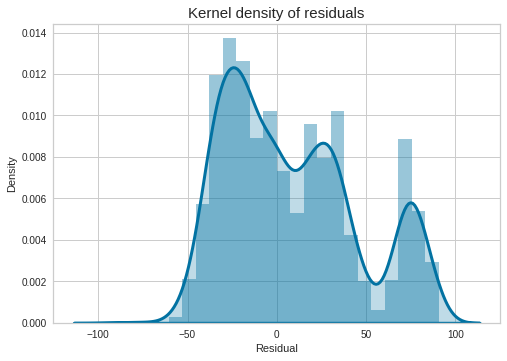

In [ ]:
plot_residual_distribution(gbm3)

Custom Training and Evaluation

In [ ]:
def custom_asymmetric_objective_2(y_true, y_pred):
    residual = (y_true - y_pred).astype("float")
    grad = np.where(residual>0, -2*15.0*residual, -2*residual)
    hess = np.where(residual>0, 2*15.0, 2.0)
    return grad, hess

In [ ]:
# make new model on new value
gbm4 = lightgbm.LGBMRegressor(alpha=0.95, boosting_type='gbdt', colsample_bytree=1.0,
       lambda_l2=0.001, learning_rate=0.001, max_bin=255, max_depth=-1,
       min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
       n_estimators=10000, n_jobs=-1, num_leaves=8, objective='quantile',
       random_state=0, reg_alpha=0.0, reg_lambda=0.0, silent=True,
       subsample=1.0, subsample_for_bin=200000, subsample_freq=1)

gbm4.set_params(**{'objective': custom_asymmetric_objective_2}, metrics = ["mse", 'mae'])

gbm4.fit(
    X_train,
    y_train,
    eval_set=[(X_test, y_test)],
    eval_metric=custom_asymmetric_eval,
    verbose=False,
)

[LightGBM] [Warning] lambda_l2 is set=0.001, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.001


LGBMRegressor(alpha=0.95, lambda_l2=0.001, learning_rate=0.001, max_bin=255,
              metrics=['mse', 'mae'], n_estimators=10000, num_leaves=8,
              objective=<function custom_asymmetric_objective_2 at 0x7efe65bf2ef0>,
              random_state=0, silent=True, subsample_freq=1)

In [ ]:
print(f"rMSE is {mean_squared_error(y_test, gbm4.predict(X_test),squared=False)}")

rMSE is 37.59720790089269


In [ ]:
print(f"Custom asymmetric rMSE is {custom_asymmetric_rmse(y_test, gbm4.predict(X_test))}")

Custom asymmetric rMSE is 96.83802687161155


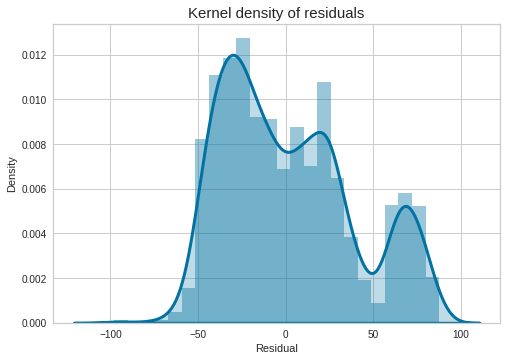

In [ ]:
plot_residual_distribution(gbm4)

In [ ]:
# asymmetric mse scores
loss_gbm  = custom_asymmetric_rmse(y_test, gbm.predict(X_test))
loss_gbm2 = custom_asymmetric_rmse(y_test, gbm2.predict(X_test))
loss_gbm3 = custom_asymmetric_rmse(y_test, gbm3.predict(X_test))
loss_gbm4 = custom_asymmetric_rmse(y_test, gbm4.predict(X_test))


In [ ]:
score_dict = {

              'LightGBM default' :
              {'asymmetric custom rmse (test)': loss_gbm,
               'symmetric rmse': mean_squared_error(y_test, gbm.predict(X_test),squared=False),
               '# boosting rounds' : gbm.booster_.current_iteration()},

              'LightGBM with hyperparameter tuning':
              {'asymmetric custom rmse (test)': loss_gbm2,
               'symmetric rmse': mean_squared_error(y_test, gbm2.predict(X_test),squared=False),
               '# boosting rounds' : gbm2.booster_.current_iteration()},


             'LightGBM with early_stopping and custom objective':
              {'asymmetric custom rmse (test)': loss_gbm3,
               'symmetric rmse': mean_squared_error(y_test, gbm3.predict(X_test),squared=False),
               '# boosting rounds' : gbm3.booster_.current_iteration()},


              'LightGBM with early_stopping, custom objective and custom validation loss':
              {'asymmetric custom rmse (test)': loss_gbm4,
               'symmetric rmse': mean_squared_error(y_test, gbm4.predict(X_test),squared=False),
               '# boosting rounds' : gbm4.booster_.current_iteration()}

             }

In [ ]:
pd.DataFrame(score_dict).T

asymmetric custom rmse (test)  \
LightGBM default                                                       117.443446   
LightGBM with hyperparameter tuning                                    117.462154   
LightGBM with early_stopping and custom objective                      106.685538   
LightGBM with early_stopping, custom objective ...                      96.838027   

                                                    symmetric rmse  \
LightGBM default                                         39.497325   
LightGBM with hyperparameter tuning                      39.417307   
LightGBM with early_stopping and custom objective        38.105619   
LightGBM with early_stopping, custom objective ...       37.597208   

                                                    # boosting rounds  
LightGBM default                                                 15.0  
LightGBM with hyperparameter tuning                            1394.0  
LightGBM with early_stopping and custom objective              3446.0  
LightGBM with early_stopping, custom objective ...            10000.0

In [ ]:
a=gbm.predict(X_test)
b=gbm2.predict(X_test)
c=gbm3.predict(X_test)
d=gbm4.predict(X_test)

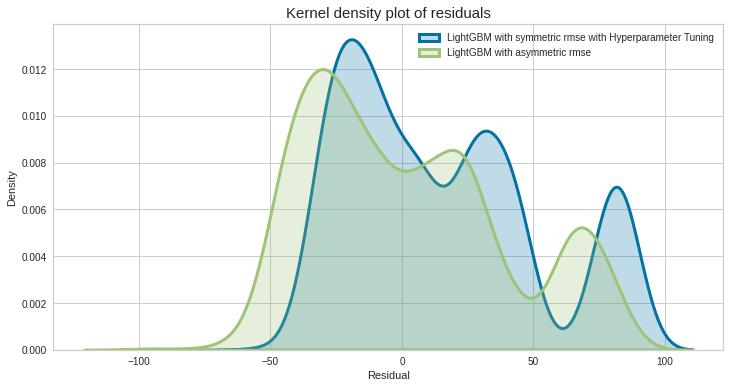

In [ ]:
fig, ax = plt.subplots(figsize=(12,6))
ax = sns.distplot(y_test - b, hist = False, kde = True,
             kde_kws = {'shade': True, 'linewidth': 3}, axlabel="Residual", label = "LightGBM with symmetric rmse with Hyperparameter Tuning")
ax = sns.distplot(y_test - d, hist = False, kde = True,
             kde_kws = {'shade': True, 'linewidth': 3}, axlabel="Residual", label = "LightGBM with asymmetric rmse")


title = ax.set_title('Kernel density plot of residuals', size=15)
plt.legend()
plt.show()

Feature Importance

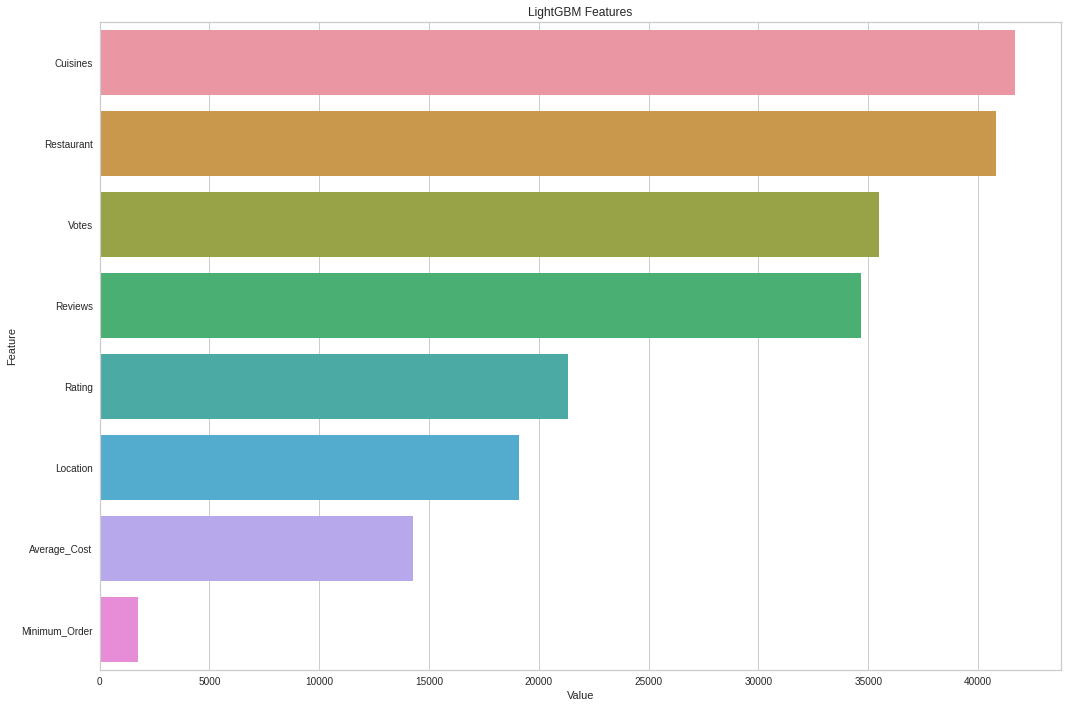

<Figure size 576x396 with 0 Axes>

In [ ]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# sorted(zip(clf.feature_importances_, X.columns), reverse=True)
feature_imp = pd.DataFrame(sorted(zip(gbm2.feature_importances_,X_train.columns)), columns=['Value','Feature'])

plt.figure(figsize=(15, 10))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('LightGBM Features')
plt.tight_layout()
plt.show()
plt.savefig('lgbm_importances-01.png')

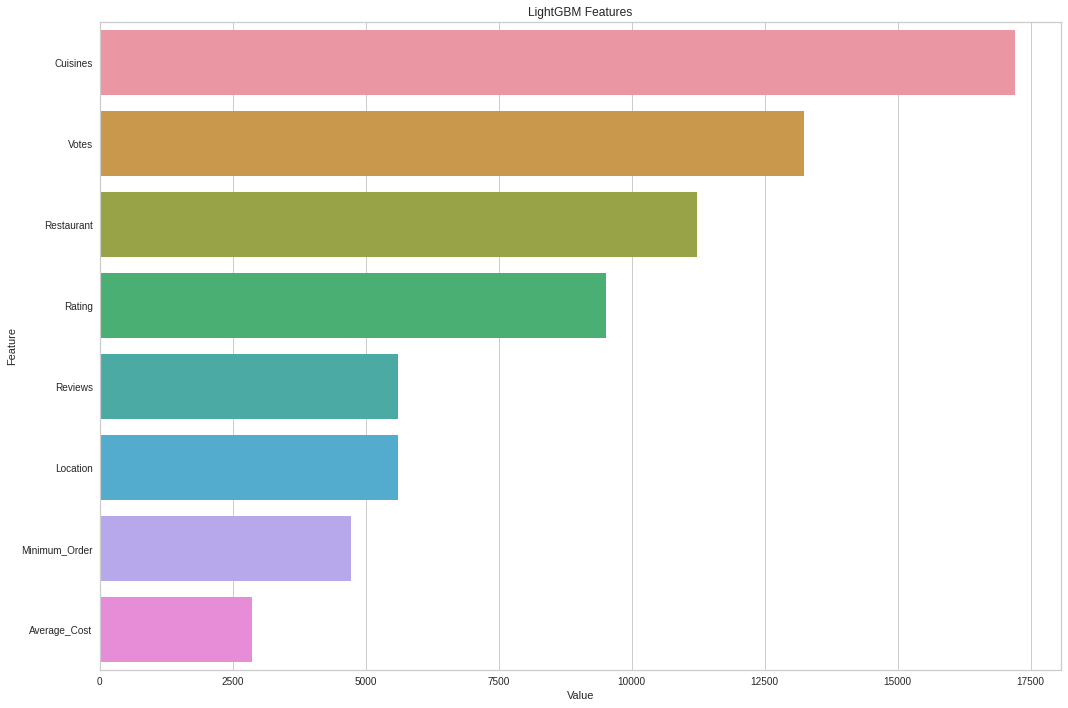

<Figure size 576x396 with 0 Axes>

In [ ]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# sorted(zip(clf.feature_importances_, X.columns), reverse=True)
feature_imp = pd.DataFrame(sorted(zip(gbm4.feature_importances_,X_train.columns)), columns=['Value','Feature'])

plt.figure(figsize=(15, 10))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('LightGBM Features')
plt.tight_layout()
plt.show()
plt.savefig('lgbm_importances-02.png')

We can observe that the Delivery Time mainly depends on the features 'Cuisines', 'Restaurant' and 'Votes'.

In [ ]:
predicted_data=pd.DataFrame()
predicted_data['predicted']=gbm2.predict(X_test)
predicted_data['overpredicted'] = gbm4.predict(X_test)
predicted_data

predicted  overpredicted
0     37.801749      52.727672
1     42.664744      59.517319
2     35.198846      46.893337
3     35.031657      42.527020
4     37.389132      55.913854
...         ...            ...
2769  40.134573      55.720150
2770  32.438580      35.908192
2771  36.684320      48.365207
2772  45.405917      87.970242
2773  37.081986      44.121497

[2774 rows x 2 columns]

Quantile Regression

0.1, 0.3, 0.5, 0.7, 0.9

In [ ]:
import matplotlib as mpl
!wget https://github.com/MaxGhenis/random/raw/master/Roboto-Regular.ttf -P /usr/local/lib/python3.6/dist-packages/matplotlib/mpl-data/fonts/ttf
mpl.font_manager._rebuild()

--2022-11-14 02:10:11--  https://github.com/MaxGhenis/random/raw/master/Roboto-Regular.ttf
Resolving github.com (github.com)... 192.30.255.112
Connecting to github.com (github.com)|192.30.255.112|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/MaxGhenis/random/master/Roboto-Regular.ttf [following]
--2022-11-14 02:10:11--  https://raw.githubusercontent.com/MaxGhenis/random/master/Roboto-Regular.ttf
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 145348 (142K) [application/octet-stream]
Saving to: ‘/usr/local/lib/python3.6/dist-packages/matplotlib/mpl-data/fonts/ttf/Roboto-Regular.ttf.3’

Roboto-Regular.ttf. 100%[===================>] 141.94K  --.-KB/s    in 0.01s   

2022-11-14 02:10:12 (11.0 MB

In [ ]:
sns.set_style('white')
DPI = 200
mpl.rc('savefig', dpi=DPI)
mpl.rcParams['figure.dpi'] = DPI
mpl.rcParams['figure.figsize'] = 6.4, 4.8  # Default.
mpl.rcParams['font.sans-serif'] = 'Roboto'
mpl.rcParams['font.family'] = 'sans-serif'

# Set title text color to dark gray (https://material.io/color) not black.
TITLE_COLOR = '#212121'
mpl.rcParams['text.color'] = TITLE_COLOR

# Axis titles and tick marks are medium gray.
AXIS_COLOR = '#757575'
mpl.rcParams['axes.labelcolor'] = AXIS_COLOR
mpl.rcParams['xtick.color'] = AXIS_COLOR
mpl.rcParams['ytick.color'] = AXIS_COLOR

In [ ]:
METHODS = ['OLS',  'Random forests', 'Gradient boosting']

QUANTILES = [0.1, 0.3, 0.5, 0.7, 0.9]
# QUANTILES.reverse()  # Test out to see if we're getting different results.

quantiles_legend = [str(int(q * 100)) + 'th percentile' for q in QUANTILES]

In [ ]:
# sns.set_palette(sns.color_palette('Blues', len(QUANTILES)))
sns.set_palette(sns.color_palette('Blues'))
# Set dots to a light gray
dot_color = sns.color_palette('coolwarm', 3)[1]
x_test = X_test.values
preds = np.array([(method, q, x)
                  for method in METHODS
                  for q in QUANTILES
                  for x in x_test])
preds = pd.DataFrame(preds)
preds.columns = ['method', 'q', 'x']
preds = preds.apply(lambda x: pd.to_numeric(x, errors='ignore'))
preds['label'] = np.resize(y_test, preds.shape[0])

In [ ]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.regression.quantile_regression as Q_reg

In [ ]:
preds_full = preds[['method', 'q', 'label']].copy(deep=True)
X_train_full = sm.add_constant(X_train)
X_test_full = sm.add_constant(X_test)

In [ ]:
preds

method    q  \
0                    OLS  0.1   
1                    OLS  0.1   
2                    OLS  0.1   
3                    OLS  0.1   
4                    OLS  0.1   
...                  ...  ...   
41605  Gradient boosting  0.9   
41606  Gradient boosting  0.9   
41607  Gradient boosting  0.9   
41608  Gradient boosting  0.9   
41609  Gradient boosting  0.9   

                                                       x  label  
0      [580.0, 17.0, 586.0, 350.0, 50.0, 42.0, 361.0,...    120  
1      [1959.0, 17.0, 104.0, 100.0, 50.0, 36.00044111...     20  
2      [1123.0, 28.0, 326.0, 100.0, 50.0, 36.0, 36.0,...     20  
3      [1404.0, 1.0, 517.0, 200.0, 50.0, 36.0, 66.0, ...     65  
4      [706.0, 28.0, 215.0, 150.0, 50.0, 29.0, 38.0, ...     45  
...                                                  ...    ...  
41605  [1682.0, 8.0, 338.0, 100.0, 50.0, 36.000441111...     80  
41606  [2321.0, 17.0, 296.0, 250.0, 50.0, 31.0, 5.0, ...     65  
41607  [1905.0, 22.0, 14.0, 150.0, 50.0, 30.0, 16.0, ...    120  
41608    [453.0, 4.0, 37.0, 100.0, 99.0, 30.0, 7.0, 2.0]    120  
41609  [195.0, 9.0, 464.0, 150.0, 50.0, 36.0, 99.0, 3...     20  

[41610 rows x 4 columns]

In [ ]:
X_test_full.shape

(2774, 9)

OLS Model

In [ ]:
from scipy.stats import norm

In [ ]:
ols_full = sm.OLS(y_train, X_train_full).fit()

In [ ]:
def ols_quantile(m, X, q):
    # m: OLS model.
    # X: X matrix.
    # q: Quantile.
    #
    # Set alpha based on q. Vectorized for different values of q.
    mean_pred = m.predict(X)
    se = np.sqrt(m.scale)
    return mean_pred + norm.ppf(q) * se

In [ ]:
preds_full.loc[preds_full.method == 'OLS', 'pred'] = np.concatenate(
    [ols_quantile(ols_full, X_test_full, q) for q in QUANTILES])

Random Forest

In [ ]:
N_ESTIMATORS = 1000
rf_full = ensemble.RandomForestRegressor(n_estimators=N_ESTIMATORS,
                                         min_samples_leaf=1, random_state=3,
                                         n_jobs=-1)
rf_full.fit(X_train_full, y_train)

def rf_quantile(m, X, q):
    rf_preds = []
    for estimator in m.estimators_:
        rf_preds.append(estimator.predict(X))
    rf_preds = np.array(rf_preds).transpose()  # One row per record.
    return np.percentile(rf_preds, q * 100, axis=1)

In [ ]:
preds_full.loc[preds_full.method == 'Random forests', 'pred'] = np.concatenate(
    [rf_quantile(rf_full, X_test_full, q) for q in QUANTILES])

Gradient Boosting Model

In [ ]:
def lgb_quantile(X_train,y_train,X,q):
  lgb = lightgbm.LGBMRegressor(objective='quantile',alpha=q,
                              random_state=33,
                              early_stopping_rounds = 250,
                              n_estimators=500,
                              boosting_type='gbdt', num_leaves=151, max_depth=- 1, learning_rate=0.01, subsample_for_bin=200000,
                              min_split_gain=0.0, min_child_weight=0.001, min_child_samples=20, subsample=1.0, subsample_freq=0,
                              colsample_bytree=.75, reg_alpha=1.3, reg_lambda=0.1,  n_jobs=- 1,
                              silent=True, importance_type='split'
                             )

  lgb.fit(X_train,y_train, eval_set=[(X_test, y_test)],
    eval_metric='l2',  # also the default
    verbose=False,)
  return lgb.predict(X)

In [ ]:
predicted_data['90th_Percentile']=lgb_quantile(X_train, y_train, X_test, 0.9)
predicted_data['10th_Percentile']=lgb_quantile(X_train, y_train, X_test, 0.1)

[LightGBM] [Warning] early_stopping_round is set=250, early_stopping_rounds=250 will be ignored. Current value: early_stopping_round=250
[LightGBM] [Warning] early_stopping_round is set=250, early_stopping_rounds=250 will be ignored. Current value: early_stopping_round=250


In [ ]:
preds_full.loc[preds.method == 'Gradient boosting', 'pred'] = np.concatenate(
    [lgb_quantile(X_train, y_train, X_test, q) for q in QUANTILES])

[LightGBM] [Warning] early_stopping_round is set=250, early_stopping_rounds=250 will be ignored. Current value: early_stopping_round=250
[LightGBM] [Warning] early_stopping_round is set=250, early_stopping_rounds=250 will be ignored. Current value: early_stopping_round=250
[LightGBM] [Warning] early_stopping_round is set=250, early_stopping_rounds=250 will be ignored. Current value: early_stopping_round=250
[LightGBM] [Warning] early_stopping_round is set=250, early_stopping_rounds=250 will be ignored. Current value: early_stopping_round=250
[LightGBM] [Warning] early_stopping_round is set=250, early_stopping_rounds=250 will be ignored. Current value: early_stopping_round=250


In [ ]:
N_ESTIMATORS = 1000
def gb_quantile(X_train, train_labels, X, q):
    gbf = ensemble.GradientBoostingRegressor(loss='quantile', alpha=q,
                                             n_estimators=N_ESTIMATORS,
                                             max_depth=3,
                                             learning_rate=0.1, min_samples_leaf=9,
                                             min_samples_split=9)
    gbf.fit(X_train, train_labels)
    return gbf.predict(X)

In [ ]:
preds.loc[preds.method == 'Gradient boosting', 'pred'] = np.concatenate(
    [gb_quantile(X_train, y_train, X_test, q) for q in QUANTILES])

In [ ]:
# pandas version rather than Keras.
def quantile_loss(q, y, f):
    # q: Quantile to be evaluated, e.g., 0.5 for median.
    # y: True value.
    # f: Fitted or predicted value.
    e = y - f
    return np.maximum(q * e, (q - 1) * e)

In [ ]:
preds=preds_full.dropna()

In [ ]:
preds['quantile_loss'] = quantile_loss(preds.q, preds.label, preds.pred)

In [ ]:
preds['method'].unique()

array(['OLS', 'Random forests', 'Gradient boosting'], dtype=object)

Plotting the Quantile Loss

In [ ]:
def plot_loss_comparison(preds):
    overall_loss_comparison = preds[~preds.quantile_loss.isnull()].\
      pivot_table(index='method', values='quantile_loss').\
      sort_values('quantile_loss')
    # Show overall table.
    print(overall_loss_comparison)

    # Plot overall.
    with sns.color_palette('Blues', 1):
        ax = overall_loss_comparison.plot.barh()
        plt.title('Total quantile loss', loc='left')
        sns.despine(left=True, bottom=True)
        plt.xlabel('Quantile loss')
        plt.ylabel('')
        ax.legend_.remove()

    # Per quantile.
    per_quantile_loss_comparison = preds[~preds.quantile_loss.isnull()].\
        pivot_table(index='q', columns='method', values='quantile_loss')
    # Sort by overall quantile loss.
    per_quantile_loss_comparison = \
        per_quantile_loss_comparison[overall_loss_comparison.index]
    print(per_quantile_loss_comparison)

    # Plot per quantile.
    with sns.color_palette('Blues'):
        ax = per_quantile_loss_comparison.plot.barh()
        plt.title('Quantile loss per quantile', loc='left')
        sns.despine(left=True, bottom=True)
        handles, labels = ax.get_legend_handles_labels()
        plt.xlabel('Quantile loss')
        plt.ylabel('Quantile')
        # Reverse legend.
        ax.legend(reversed(handles), reversed(labels))

                   quantile_loss
method                          
OLS                    13.099570
Gradient boosting      13.573213
Random forests         13.579131
method        OLS  Gradient boosting  Random forests
q                                                   
0.1      5.475573           6.629565        6.743205
0.3     11.727907          11.378274       12.093854
0.5     15.561274          15.667356       15.714672
0.7     17.042947          16.683260       17.909229
0.9     15.690149          17.507613       15.434697


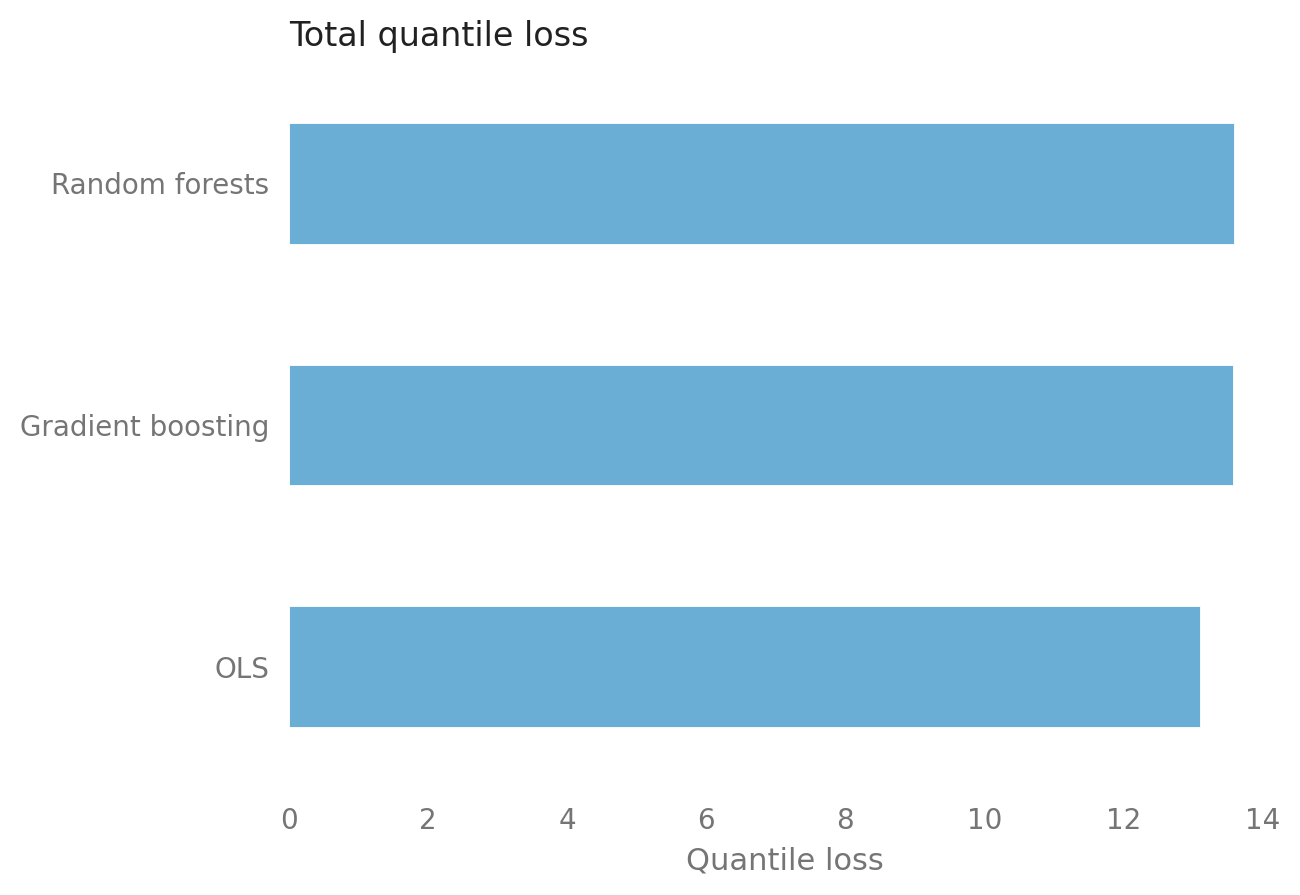

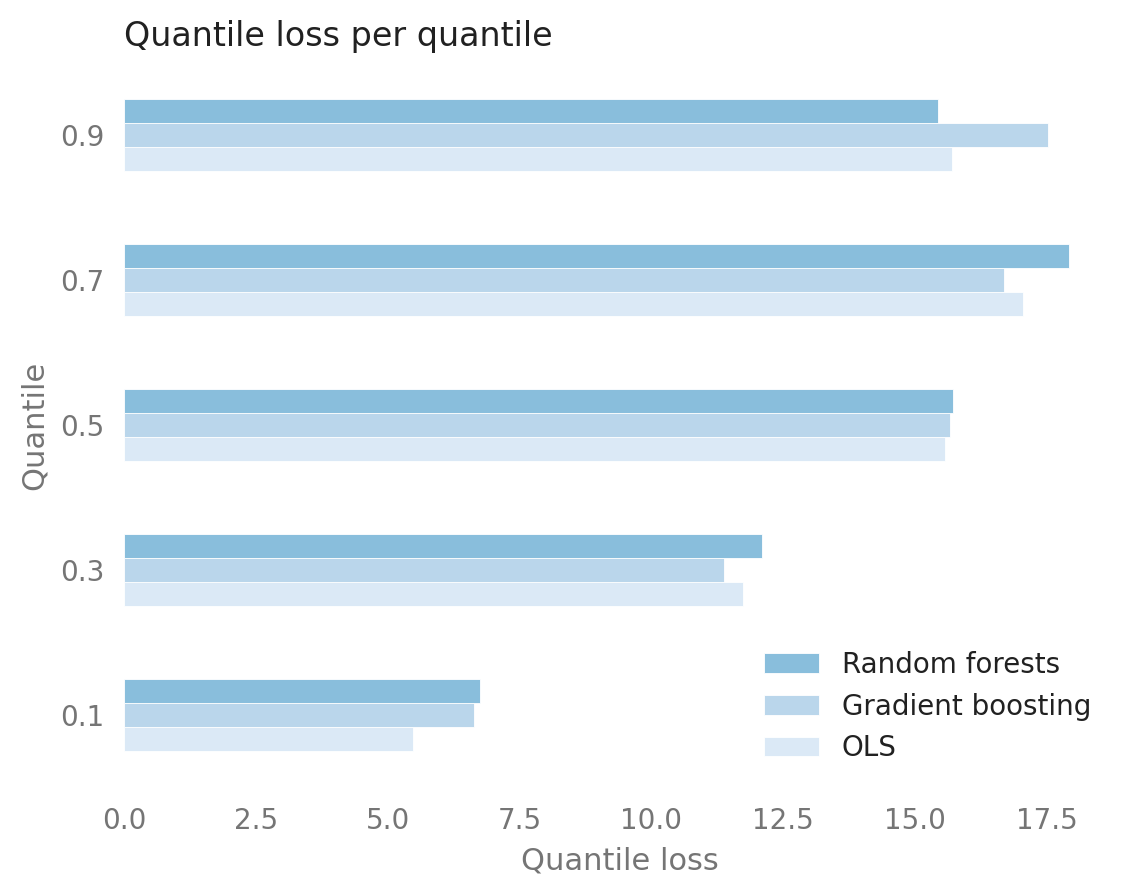

In [ ]:
plot_loss_comparison(preds)

The above charts hows that OLS had the lowest quantile loss.

Using this information we can create a confidence interval and check how often was the actual delivery time between 10th and 90th Confidence Interval

In [ ]:
lgb_01=preds[(preds['method']=='OLS') & (preds['q']==0.1)]['pred'].values
lgb_05=preds[(preds['method']=='OLS') & (preds['q']==0.5)]['pred'].values
lgb_09=preds[(preds['method']=='OLS') & (preds['q']==0.9)]['pred'].values

In [ ]:
df_interval = pd.DataFrame([lgb_01,lgb_05,lgb_09,y_test.values]).T

In [ ]:
a =['lower','middle','upper','label']

In [ ]:
df_interval.columns = a

In [ ]:
df_interval.isna().sum()

lower     0
middle    0
upper     0
label     0
dtype: int64

In [ ]:
df_interval.loc[(df_interval.label>df_interval.lower) & (df_interval['label']< df_interval['upper']),'check']=1
df_interval.loc[(df_interval.label<df_interval.lower) | (df_interval['label']> df_interval['upper']),'check']=0

In [ ]:
df_interval=df_interval.dropna()

In [ ]:
np.sum(df_interval['check'])/len(df_interval)*100

27.108868060562365

About 27% of all orginial values were in the confidence interval